# Import required modules

In [1]:
import os
import pandas as pd
import numpy as np
from itertools import combinations, product
from time import time
import matplotlib.pyplot as plt 
from sklearn.linear_model import Lasso
import scipy.stats as ss
import warnings
from collections import Counter
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from IPython.display import HTML
from jupyter_jsmol import JsmolView
import pathlib


import nglview
from ase.units import J

from compressed_sensing.sisso import SissoRegressor
from compressed_sensing.combine_features import combine_features
from compressed_sensing.scatter_plot import  show_scatter_plot
from compressed_sensing.visualizer import Visualizer
from sissopp import Inputs, FeatureSpace, SISSORegressor, FeatureNode, Unit
from sissopp.py_interface import read_csv
from sissopp.py_interface.import_dataframe import get_unit

from atomicfeaturespackage.atomicproperties import atomic_properties_lda2015
from nomad import client, config
from nomad.client.archive import ArchiveQuery
from nomad.metainfo import units
import nest_asyncio
nest_asyncio.apply()

# set display options for the notebook 
# %matplotlib inline
warnings.filterwarnings('ignore')

_ColormakerRegistry()

Loading BokehJS ...

# Get the data

First we generate data from known potential (LJ) plus some noise.

$V(r)=4\epsilon\left[\left(\frac{\sigma}{r}\right)^{12}-\left(\frac{\sigma}{r}\right)^{6}\right]+\eta(r)$

In [26]:
def lj(r,eps,sig):
    return 4*eps*((sig/r)**12.-(sig/r)**6.)

def lj_noisy(r,eps,sig,A):
    return lj(r,eps,sig)+A*np.random.uniform(-1,1)

In [27]:
lj_noisy(3,1,1,1)


-0.23477518103761866

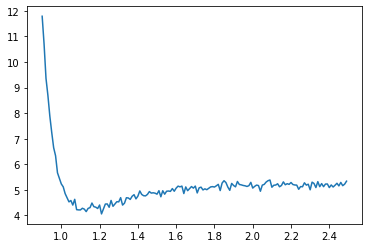

In [51]:
x = np.arange(90, 250)/100
y = lj_noisy(x,1,1,10)

noise = np.random.normal(-1, .1, x.shape)

y=y+noise

plt.plot(x,y) 

In [ ]:
def get_features(elements, features, rename_dict={}):    
    features_data = [[atomic_properties_lda2015.symbol(el).get('atomic_'+f) for f in features] for el in elements]
    df_features = pd.DataFrame(features_data, index=elements, columns=features).sort_values('number')
    df_features = df_features.rename(columns=rename_dict)
    feautures = df_features.columns.tolist()
    return df_features, features

# get features from atomicfeaturespackage
features = ['number', 'r_s', 'r_p', 'r_d', 'period', 'ea', 'ip', 'homo', 'lumo']
rename_dict = {'number': 'Z', 'ea': 'EA', 'ip': 'IP', 'homo': 'E_HOMO', 'lumo':'E_LUMO'}
elements = np.unique(df_target[['A', 'B']])

df_features, features = get_features(elements, features, rename_dict=rename_dict)
df_features

In [ ]:
def sort_AB_wrt_electronegativity(df_target, df_features):
    df_features['EN'] = -(df_features['IP'] + df_features['EA'])/2
    df_en = df_target[['A', 'B']].merge(df_features['EN'], left_on='A', right_index=True)
    df_en = df_en.merge(df_features['EN'], left_on='B', right_index=True, suffixes=('_A', '_B'),)
    df_en = df_en.sort_index()
    AB = np.where(df_en['EN_A'] < df_en['EN_B'], [df_en['A'], df_en['B']], [df_en['B'], df_en['A']])
    df_target.index = np.where(AB[0]==AB[1], AB[0]+'2', AB.sum(0),)
    df_target[['A', 'B',]] = AB.T
    df_features.drop('EN', axis=1, inplace=True)
    return df_target

# sort A and B in chemical formula AB with respect to electronegativity of A and B
df_target = sort_AB_wrt_electronegativity(df_target, df_features)

In [ ]:
def merge_target_feature(df_target, df_features, suffixes=('(A)', '(B)')):
    df = df_target.merge(df_features, left_on='A', right_index=True)
    df = df.merge(df_features, left_on='B', right_index=True, suffixes=suffixes)
    return df

# merge target and feature data frame
df = merge_target_feature(df_target, df_features)
df

Let us look at the distribution of the energy differences.

In [ ]:
plt.hist(df['energy_diff'].tolist(), bins=30)
plt.xlabel('$\Delta E$')
plt.ylabel('Counts')
plt.show()
print('Standard deviation: %.3f eV/atom' % df['energy_diff'].values.std())

With the SISSO method, we are able to predict the energy differences from the atomic features with an accuracy of 0.035 eV/atom. However, due to computational limit we will target an accuracy of around 0.1 eV/atom in this tutorial.  

Now let us define a function get_data that uses the data frame df to define the target vector $\mathbf{P}$ of energy differences and constructs the descriptor matrix $\mathbf{D}$ of combined features. The arguments selected_feature_list and allowed_operations specify which primary features and which arithmetic operations should be used to build the new derived features.

In [ ]:
def get_data(selected_feature_list, allowed_operations):
    # add both '(A)', '(B)' to each feature
    selected_featureAB_list = [f+A_or_B for f in selected_feature_list for A_or_B in ['(A)', '(B)']]
    
    # extract energy differences and selected features from df 
    P = df['energy_diff'].values
    df_features = df[selected_featureAB_list]
    
    
    # derive new features using allowed_operations
    df_combined = combine_features(df=df_features, allowed_operations=allowed_operations)
    return P, df_combined

In [ ]:
# selected_feature_list = ['IP', 'EA', 'E_HOMO', 'E_LUMO', 'r_s', 'r_p', 'r_d', 'Z', 'period']
selected_feature_list = ['r_s', 'r_p']

# allowed_operations = ['+', '-', '|-|', '/' '^2', '^3',  'exp']
allowed_operations = ['+']

P, df_D = get_data(selected_feature_list, allowed_operations)

# print derived features
df_D

# Determining low-dimensional descriptors with the $\ell_0$ method

<div style="list-style:disc; margin: 2px;padding: 10px;border: 0px;border:8px double   green; font-size:16px;padding-left: 32px;padding-right: 22px; width:89%">
<li> Perform an $\ell_0$-regularization to identify the best low dimensional descriptors using the primary features.</li>
<li> Show that non-linear functions of the primary features improve the models significantly. </li>
<li> See that the $\ell_0$-regularization can rapidly become computational infeasible.</li>
</div>

Our target is to find the best low dimensional descriptor for a linear model $\mathbf{P} = \mathbf{D^\ast}\mathbf{c^\ast}$, where $\mathbf{c^\ast}$ is the vector of nonzero elements of the solution vector $\mathbf{c}$ and $\mathbf{D^\ast}$ is the matrix of the columns of $\mathbf{D}$ corresponding to the nonzero elements of $\mathbf{c}$. The $\ell_0$ regularization

$\text{argmin}_{\mathbf{c} \in \mathbb{R}^{m}} \{\|\mathbf{P} - \mathbf{D}\mathbf{c}\|^2_2 +\lambda \|\mathbf{c}\|_0\}$

provides exactly what we want. It is defined in the following and solved combinatorial:

In [ ]:
def L0(P, D, dimension):
    n_rows, n_columns = D.shape
    D = np.column_stack((D, np.ones(n_rows)))
    SE_min = np.inner(P ,P)
    coef_min, permu_min = None, None
    for permu in combinations(range(n_columns), dimension):
        D_ls = D[:, permu + (-1,)]
        coef, SE, __1, __2 = np.linalg.lstsq(D_ls, P, rcond=-1)
        try:
            if SE[0] < SE_min: 
                SE_min = SE[0]
                coef_min, permu_min = coef, permu
        except:
            pass
    RMSE = np.sqrt(SE_min/n_rows)
    return RMSE, coef_min, permu_min

Perform the $\ell_0$-regularization for different dimensions (numbers of non-zero coefficients in the model) and see the root mean square errors (RMSE) and the selected features.

In [ ]:
df_D

In [ ]:
selected_feature_list = ['r_s', 'r_p', 'r_d', 'EA', 'IP']
allowed_operations = []

P, df_D = get_data(selected_feature_list, allowed_operations)
features_list = df_D.columns.tolist()
D = df_D.values

print("     RMSE   Best desriptor")
for dim in range(1,11):
    RMSE, coefficients, selected_indices = L0(P,D,dim)
    print('%2sD: %.5f' % (dim, RMSE), [features_list[i] for i in selected_indices])

The result of performing the $\ell_0$-regularization shows that the accuracy converges fast, e.g. we could leave out some components in the linear model without decreasing the accuracy. The second observation is that a linear model of the atomic features is not enough to describe the RS-ZB energy differences. A way out could be using non-linear machine learning models, e.g. kernel ridge regression or a neural network, instead of linear regression. Another way is to put the non-linearity into the descriptors by building algebraic combinations of the atomic features and mapping the few best of these more complex features onto the target again with a linear model. 

Run the following script to build larger feature spaces of more complex features and select the best 1D, 2D and 3D descriptor for a linear model using $\ell_0$-regularization. Plot the results afterwards. How does the accuracy of the models change? How does the feature space size and the dimension of the descriptors depend on the needed time to solve the $\ell_0$-problem?

In [ ]:
selected_feature_list = ['r_s', 'r_p', 'r_d', 'EA', 'IP']
op_lists = [[], ['+','|-|'], ['+','|-|','exp'], ['+','|-|','exp', '^2'] ]
X  = []
Errors, Time = np.empty([3,len(op_lists)]), np.empty([3,len(op_lists)])

for n_op, allowed_operations in enumerate(op_lists):
    P, df_D = get_data(selected_feature_list, allowed_operations)
    features_list = df_D.columns.tolist()
    D = df_D.values
    
    number_of_features = len(features_list)
    X.append(number_of_features)
    for dim in range(1,4):
        t1= time()
        RMSE, coefficients, selected_indices = L0(P,D,dim)
        t2 = time()-t1             
        
        Time [dim-1][n_op] = t2
        Errors[dim-1][n_op] = RMSE 
        
        print("n_features: %s; %sD  RMSE: %.3f  best features: %s" 
              %(len(features_list), dim, RMSE, [features_list[i] for i in selected_indices]))

In [ ]:
#plot
f, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(12,8))
ax1.set_xlabel('Feature space size')
ax2.set_xlabel('Feature space size')
ax1.set_ylabel('RMSE [eV/atom]')
ax2.set_ylabel('Time [s]')
#ax2.set_yscale('log')

for dim in range(1,4):
    ax1.plot(X, Errors[dim-1], 's-', label='%sD' %dim)
    ax2.plot(X, Time[dim-1], 's-', label='%sD' %dim)
ax2.legend(loc='best')
plt.show()

Assume now that we would like to include thousands or millions of (more) complex features to obtain more accurate models...

# Approximations to the $\ell_0$ method
<div style="list-style:disc; margin: 2px;padding: 10px;border: 0px;border:8px double   green; font-size:16px;padding-left: 32px;padding-right: 22px; width:89%">
<li >Perform a LASSO minimization and the SISSO method.</li>
<li >Compare the solutions with the ones from the $\ell_0$ method.</li>
</div>

### The LASSO


One state-of-the art approximation to the $\ell_0$ method is the LASSO: 

$\text{argmin}_{\mathbf{c} \in \mathbb{R}^{m}} \{\|\mathbf{P} - \mathbf{D}\mathbf{c}\|^2_2 +\lambda \|\mathbf{c}\|_1\}$.

Before performing the LASSO regression we standardize the data to have mean 0 and variance 1, since otherwise the $\ell_2$-norm of a column would affect bias its contribution to the model. <br>
Note that we can use the LASSO also only for feature selection. We use then a least-square model with the selected features afterwards instead of the LASSO model directly.

In [ ]:
def lasso_fit(lam, P, D, feature_list):
    #LASSO
    D_standardized = ss.zscore(D)
    lasso =  Lasso(alpha=lam)
    lasso.fit(D_standardized, P)
    coef =  lasso.coef_
    
    # get strings of selected features
    selected_indices = coef.nonzero()[0]
    selected_features = [feature_list[i] for i in selected_indices]
    
    # get RMSE of LASSO model
    P_predict = lasso.predict(D_standardized)
    RMSE_LASSO = np.linalg.norm(P-P_predict) / np.sqrt(82.)

    #get RMSE for least-square fit
    D_new = D[:, selected_indices]
    D_new = np.column_stack((D_new, np.ones(82)))
    RMSE_LS = np.sqrt(np.linalg.lstsq(D_new, P, rcond=-1)[1][0]/82.)
        
    return RMSE_LASSO, RMSE_LS, coef, selected_features

$\lambda$ regulates the sparsity of the coefficient vector of the model. Get the data and try different $\lambda$ by adjusting the varibale lam. How good does LASSO (directly or with a least-square fit afterwards) approximate the L0-method (when the same feature space is used for both)?

In [ ]:
#import Data
selected_feature_list = ['r_s', 'r_p', 'r_d', 'EA', 'IP']
allowed_operations = ['+','|-|','exp', '^2']
P, df_D = get_data(selected_feature_list, allowed_operations)
D = df_D.values
features_list = df_D.columns.tolist()

In [ ]:
# change lam between 0.02 and 0.34, e.g. 0.34, 0.30, 0.20, 0.13, 0.10, 0.02
lam = 0.2

RMSE_LASSO, RMSE_LS, coef, selected_features = lasso_fit(lam, P, D, features_list)
plt.bar(range(len(coef)), np.abs(coef))
plt.xlabel("Coefficient index $i$")
plt.ylabel("$|c_i|$")

print("lambda: %.3f\t dimension of descriptor: %s\t RMSE_LASSO: %.3f\t RMSE_LS: %.3f" 
      %(lam, len(selected_features), RMSE_LASSO, RMSE_LS))
print(pd.DataFrame({'features':np.array(selected_features), 'abs(nonzero_coefs_LASSO)': np.abs(coef[coef.nonzero()])}))
plt.show()    

Hint:
Compare these results to the L0 results you have obtained before from the same feature space, copied and pasted in here:<br>
"Number of total features generated: 115 <br>
features: 115; 1D  RMSE: 0.296667841349  best features: ['(r_p(A)+r_d(B))'] <br>
features: 115; 2D  RMSE: 0.194137970112  best features: ['(r_s(B)+r_p(A))', '(r_s(B)+r_p(A))^2'] <br>
features: 115; 3D  RMSE: 0.170545592998  best features: ['(r_s(B)+r_p(A))', '(r_s(B)+r_p(A))^2', 'exp(r_s(B)+r_p(A))']"

### The SISSO method

In [ ]:
#import Data
selected_feature_list = ['r_s', 'r_p', 'r_d', 'EA', 'IP']
allowed_operations = ['+','|-|','exp', '^2']
P, df_D = get_data(selected_feature_list, allowed_operations)
D = df_D.values
features_list = df_D.columns.tolist()

Now apply the SISSO algorithm. How does the SISSO method compare to the LASSO and to the $\ell_0$-regularization in terms of accuracy (again when using the same feature space)? How fast is SISSO compared to the $\ell_0$-regularization? How does n_features_per_sis_iter (the number of features collected per sis iteration) affect the performance? Note, that for n_features_per_sis_iter=1 SISSO becomes the so-called orthogonal matching pursuit, another well-known compressed sensing method.

In [ ]:
sisso = SissoRegressor(n_nonzero_coefs=3, n_features_per_sis_iter=10)

sisso.fit(D, P)
sisso.print_models(features_list)

# Run the SISSO method with a (relatively) big feature space
<div style="list-style:disc; margin: 2px;padding: 10px;border: 0px;border:8px double   green; font-size:16px;padding-left: 32px;padding-right: 22px; width:89%">
<li>Reproduce the results from the <a href="http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.114.105503" target="_blank">reference publication</a>  by including further features.</li>
<li>Visualize the 2D descriptors in a structure map.</li>
<li>Experiment with different settings and investigate the influence of the input parameters on the results. (OPTIONAL)</li>
</div>
Note the size of the feature space, the needed time to run the code and the accuracy (using the default settings)!
To deal with larger feature spaces, note that in this chapter an optimized c++ implementation of the SISSO code will be used.

In [ ]:
# here we define a different dataframe to make it compatible with the c++ implementation of SISSO

# merge target and feature data frame
df_plus = merge_target_feature(df_target, df_features, suffixes=('_A', '_B'))

# add Zunger's r_pi and r_sigma
df_plus['r_pi']    = abs(df_plus['r_p_A'] - df_plus['r_s_A']) + abs(df_plus['r_p_B'] + df_plus['r_s_B'])
df_plus['r_sigma'] = abs(df_plus['r_p_A'] + df_plus['r_s_A']  -    (df_plus['r_p_B'] + df_plus['r_s_B']))

df_plus = df_plus.rename(columns={'Z_A': 'Z_A (nuc_charge)',
                                  'Z_B': 'Z_B (nuc_charge)',
                                  'period_A': 'period_A (unitless)',
                                  'period_B': 'period_B (unitless)',
                                  'IP_A': 'IP_A (eV_IP)',
                                  'IP_B': 'IP_B (eV_IP)',
                                  'EA_A': 'EA_A (eV_IP)',
                                  'EA_B': 'EA_B (eV_IP)',
                                  'E_HOMO_A': 'E_HOMO_A (eV)',
                                  'E_HOMO_B': 'E_HOMO_B (eV)',
                                  'E_LUMO_A': 'E_LUMO_A (eV)',
                                  'E_LUMO_B': 'E_LUMO_B (eV)',
                                 })
df_plus_reduced = df_plus.drop(['A', 'B', 'min_struc_type'], axis=1)     

In [ ]:
n_nonzero_coefs=3
n_features_per_sis_iter=50
selected_features = ['r_s_A', 'r_p_A', 'r_d_A', 'EA_A', 'IP_A', 'r_s_B', 'r_p_B', 'r_d_B', 'EA_B', 'IP_B']
selected_ops = ['add', 'abs_diff', 'exp', 'sq', 'div']

inputs = read_csv(
    df_plus_reduced, 
    prop_key="energy_diff",
    cols=selected_features,
    max_rung=2,
    leave_out_frac=0.0
    )
inputs.allowed_ops = selected_ops
inputs.n_sis_select = n_features_per_sis_iter
inputs.n_dim = 3
inputs.max_rung = 2
inputs.n_residual = 1
inputs.n_model_store = 1
inputs.calc_type = "regression"
inputs.leave_out_inds = []
inputs.task_sizes_train = [82]
inputs.task_sizes_test = [0]
inputs.sample_ids_train = df_plus_reduced.index.tolist()
inputs.prop_train = df_plus_reduced["energy_diff"].to_numpy()
inputs.prop_test = np.array([])
inputs.prop_label = "energy_diff"
inputs.prop_unit = Unit("eV")
inputs.task_names = ["all_mats"]

feat_space = FeatureSpace(inputs)

sisso = SISSORegressor(inputs, feat_space)

sisso.fit()
for i in range(n_nonzero_coefs):
    print(str(i+1)+'D model')
    print("RMSE: {:.4} | Descriptor: {}".format(sisso.models[i][0].rmse, sisso.models[i][0]))
    string = "c0:{:.4}".format(sisso.models[i][0].coefs[0][-1])
    for j in range(i+1):
        string = string + str("  |  a"+str(j)+":{:.4}".format(sisso.models[i][0].coefs[0][j]))
    print(string + '\n')

Next, plot an interactive 2D structure map using the 2D descriptor. Run the SISSO method for 2 non zero coefficients.

In [ ]:
n_nonzero_coefs=2
n_features_per_sis_iter=50
selected_features = ['r_s_A', 'r_p_A', 'r_d_A', 'EA_A', 'IP_A', 'r_s_B', 'r_p_B', 'r_d_B', 'EA_B', 'IP_B']
selected_ops = ['add', 'abs_diff', 'exp', 'sq', 'div']

inputs = read_csv(
    df_plus_reduced, 
    prop_key="energy_diff",
    cols=selected_features,
    max_rung=2,
    leave_out_frac=0.0
    )
inputs.allowed_ops = selected_ops
inputs.n_sis_select = n_features_per_sis_iter
inputs.n_dim = 2
inputs.max_rung = 2
inputs.n_residual = 1
inputs.n_model_store = 1
inputs.calc_type = "regression"
inputs.leave_out_inds = []
inputs.task_sizes_train = [82]
inputs.task_sizes_test = [0]
inputs.sample_ids_train = df_plus_reduced.index.tolist()
inputs.prop_train = df_plus_reduced["energy_diff"].to_numpy()
inputs.prop_test = np.array([])
inputs.prop_label = "energy_diff"
inputs.prop_unit = Unit("eV")
inputs.task_names = ["all_mats"]

feat_space = FeatureSpace(inputs)

sisso = SISSORegressor(inputs, feat_space)

sisso.fit()
for i in range(n_nonzero_coefs):
    print(str(i+1)+'D model')
    print("RMSE: {:.4} | Descriptor: {}".format(sisso.models[i][0].rmse, sisso.models[i][0]))
    string = "c0:{:.4}".format(sisso.models[i][0].coefs[0][-1])
    for j in range(i+1):
        string = string + str("  |  a"+str(j)+":{:.4}".format(sisso.models[i][0].coefs[0][j]))
    print(string + '\n')

Below the plot containing all octet binary materials, shown in the coordinate reference system given by the SISSO descriptors. By hovering over a point in the plot, information regarding that compound is displayed. By clicking a point, an interactive 3D visualization of the most stable structure will be displayed below the plot. To facilitate comparison between different materials, we make available two separate viewers. The specific viewer to be employed for visualization can be selected with a check box placed on top-right of each visualizer. Once a compound is selected from the plot, the marker on the plot changes shape accordingly to a marker that is specific of the viewer and whose shape is shown next to the checkbox. The name of the compound viewed is shown on top of the visualizer, and it is also possible to modify the name in the text box with the name of another compound, which can be displayed by clicking the "Display" button. Consequently, the new compound is also marked on the plot, that allows to easily identify the position of each compound in the plot. Note that the structures of all compounds were stored in a .xyz file at the beginning of the tutorial, i.e. using the function 'write_xyz'.

The markers represent the compounds and their colors the reference energy differences. How well does the descriptor separate the compounds with respect to their crystal structure?

In [ ]:
visualizer=Visualizer(df, sisso, feat_space)
visualizer.show()

# Predicting new materials (extrapolation)
<div style="list-style:disc; margin: 2px;padding: 10px;border: 0px;border:8px double   green; font-size:16px;padding-left: 32px;padding-right: 22px; width:89%">
<li>Perform a leave-one-out cross-validation (LOOCV) using SISSO.</li>
<li>Analyze the prediction accuracy and how often the same descriptor is selected.</li>
</div>

We have seen that we can fit the energy differences of materials accurately. But what about predicting the energy difference of a 'new' material (which was not included when determining the model)? We test the prediction performance via LOOCV.  In a LOOCV for each material the following procedure is performed: the selected material is excluded, the model is built on the remaining materials and the model accurcy is tested on the excluded material. This means that we need to run SISSO function 82 times. <br>
Get the data in the next cell and run the LOOCV  one cell after. Note that running the LOOCV  could take up to ten minutes. Use the remaining two cells of this chapter to analyse the results.<br>
How is the prediction error compared to the fitting error? How often is the same descriptor selected? Are there materials that yield an outlying high/low error? 

In [ ]:
# get the data
selected_feature_list = ['IP', 'EA', 'r_s', 'r_p','r_d']
allowed_operations = ['+','|-|','exp', '^2', '/']

P, df_D = get_data(selected_feature_list, allowed_operations)
features_list = df_D.columns.tolist()
chemical_formulas = df_D.index.tolist()
D = df_D.values

In [ ]:
# Leave-one-out cross-validation
n_compounds = len(P)
dimensions = range(1, 4)
features_count = [[] for i in range(3)]
P_predict = np.empty([len(dimensions), n_compounds])

sisso = SissoRegressor(n_nonzero_coefs=3, n_features_per_sis_iter=10)
loo = LeaveOneOut()

for indices_train, index_test in loo.split(P):
    i_cv = index_test[0]
    print('%2s) Leave out %s: Ediff_ref = %.3f eV/atom' 
          % (index_test[0]+1, chemical_formulas[i_cv], P[i_cv]))
        
    sisso.fit(D[indices_train], P[indices_train])
    sisso.print_models(features_list)    
    
    for dim in dimensions:      
        features = [features_list[i] for i in sisso.l0_selected_indices[dim - 1]]
        predicted_value = sisso.predict(D[index_test], dim=dim)[0]
        
        features_count[dim-1].append( tuple(features) )        
        P_predict[dim-1, i_cv] = predicted_value
        
        print('Ediff_predicted(%sD) = %.3f eV/atom' %(dim, predicted_value))
    print('-----')

In [ ]:
#Plot Prediction errors
prediction_errors = np.linalg.norm(P-P_predict, axis=1)/np.sqrt(n_compounds)
xs = [P] *3
ys = P_predict
legend = ['%sD, RMSE = %.3f eV/atom' %(dim, prediction_errors[dim-1]) for dim in dimensions]
data_point_labels = [df.index.tolist()]*3

show_scatter_plot(xs, ys, data_point_labels=data_point_labels, 
                  x_label='E_diff_DFT', y_label='E_diff_predicted', legend=legend, unit='eV/atom')

In [ ]:
# Print descriptor selection frequency
print("Descriptor selection frequency")
for dim in dimensions:    
    df_frequency = pd.DataFrame( Counter(features_count[dim-1]).most_common(10), columns=['Features', 'Frequency'] )
    print('-----------------\n%sD:\n%s' % (dim, df_frequency))

# create table to display errors and models
feat = np.array(features_count).flatten('F')
Pred = np.array(P_predict).flatten('F')
Pred_errors = np.abs(P-P_predict).flatten('F')
Ref_values = [r for p in P for r in [p,p,p] ]
Mats = [m for mat in chemical_formulas for m in [mat, mat, mat] ]
Dims = ['1D','2D','3D'] * n_compounds

df_loo = pd.DataFrame(list(zip(Ref_values,Pred,Pred_errors,feat)), index = [Mats,Dims],
                  columns=['P_ref[eV]', 'P_pred[eV]', 'abs. error [eV]', 'Selected features'])

#  if you do not want to sort the data frame by the prediction error comment out the nex line 
df_loo = df_loo.sort_values('abs. error [eV]', ascending=False)
pd.set_option('display.expand_frame_repr', False)

display(df_loo)

## Kernel ridge regession
It is instructive to compare the performance of the just identified model with a model trained with the popular kernel ridge regression (KRR) approach, by using the same list of atomic features as input. 
KRR solves a $\ell_2$ regularized linear regression problem, with (typically) a nonlinear kernel.
This can be descirbed in the following manner. The $\ell_2$ regularized linear regression problem is:

$\text{argmin}_{\mathbf{c} \in \mathbb{R}^{m}} \{\|\mathbf{P} - \mathbf{D}\mathbf{c}\|^2_2 +\lambda \|\mathbf{c}\|_2\}$.

Its solution is:

$\mathbf{c} = \left( \mathbf{D}^\top \mathbf{D} + \lambda \mathbf{I} \right)^{-1} \mathbf{D}^\top \mathbf{P}$

Acoording to Hilbert space representaiton theorem, we can write the solution vector $\mathbf{c}$ as a linear expansion over the data points represented acoording to the chosen descriptor. In other words, $\mathbf{c}$ can be represented as a linear expansion over the rows $\mathbf{d}_j$ of the matrix $\mathbf{D}$.

$\mathbf{c} = \sum_j \alpha_j \mathbf{d}_j $

This rewriting leads to the equivalent problem:

$\text{argmin}_{\boldsymbol{\alpha} \in \mathbb{R}^{N}} \{\|\mathbf{P} - \mathbf{K}\boldsymbol{\alpha}\|^2_2 +\lambda \boldsymbol{\alpha}^\top \mathbf{K} \boldsymbol{\alpha} \} \quad (1)$,

where the kernel $\mathbf{K}$ is: $K_{ij} = < \mathbf{d}_i, \mathbf{d}_j > $.

The rewritten problem has solution $\boldsymbol{\alpha} = \left( \mathbf{K} + \lambda \mathbf{I} \right)^{-1} \mathbf{P} \quad (2)$

This rewriting did not add anything to the regularized linear regression approoach. If, however, we now expand the vector $\mathbf{c}$ as an expansion of nonlinear functions $\Phi()$ of the vectors $\mathbf{d}_j: 

$\mathbf{c} = \sum_j \alpha_j \Phi(\mathbf{d}_j) $

and the kernel as: $K_{ij} = < \Phi(\mathbf{d}_i), \Phi(\mathbf{d}_j)> $, one can prove that the same problem (1) with the same solution (2) holds. Normally, people do not specify the function $\Phi()$, but rahter the kernel.
Actually, $\Phi()$ does not need to be known at all. We refer to the specialized literature on KRR for more details on this method.

Here, we make use of the Gaussian kernel, i.e., the most popular one:

$K(x, y) = \exp(-\gamma ||x-y||^2)$.

The parameters $\lambda$ and $\gamma$ are called <i> hyperparameters </i> and are set via CV. 
Specifically, at each LOOCV step, the hyperparameters ($\ell_2$-regularization parameter $\lambda$ and inverse gaussian width $\gamma$) are optimized via a grid search and a so-called 5-fold cross-validation on the training set. This means splitting the training set in 5 subsets, 1 subset is used for evaluating the performance (RMSE) and the other 4 for training. The procedure is repeated 5 times by changing the test subset and the overall perfrmance is the RMSE over all repetitions. 

What can one observe by comparing the SISSO and KRR results?

In [ ]:
selected_feature_list = ['IP', 'EA', 'r_s', 'r_p','r_d']
allowed_operations = []

P, df_D = get_data(selected_feature_list, allowed_operations)
features_list = df_D.columns.tolist()
D = df_D.values

In [ ]:
kr = GridSearchCV(KernelRidge(kernel='rbf'), cv=5,
                  param_grid={"alpha": np.logspace(-3, 0, 5),
                              "gamma": np.logspace(-2, 1, 5)})
P_predict_kr = []
loo = LeaveOneOut()
for indices_train, index_test in loo.split(P):
    kr.fit(D[indices_train], P[indices_train])
    print("%2i Ediff_ref: %.3f, Ediff_pred: %.3f, hyperparameters: {'lambda': %.3f, 'gamma':%.3f}" 
          % (index_test[0], P[index_test], kr.predict(D[index_test]), 
          kr.best_params_['alpha'], kr.best_params_['gamma']))
    P_predict_kr.append(kr.predict(D[index_test])[0])


In [ ]:
prediction_rmse_kr = np.linalg.norm(np.array(P_predict_kr) - P)/np.sqrt(P.size)

xs = [P, P]
ys = [P_predict[-1], P_predict_kr,]
legend = ['SISSO 3D, RMSE = %.3f eV/atom' % prediction_errors[dim-1], 
          'KR, RMSE = %.3f eV/atom' % prediction_rmse_kr]
data_point_labels = [df.index.tolist()]*2

show_scatter_plot(xs, ys, data_point_labels=data_point_labels, 
                  x_label='E_diff_DFT', y_label='E_diff_predicted', legend=legend, unit='eV/atom')